In [31]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob as gl
import ali_offline_demod as dm


import imp
imp.reload(dm)

<module 'ali_offline_demod' from '/home/matt/readout/host/ali_offline_demod.py'>

In [2]:
path = '/home/matt/Documents/20240124_LNA3_Flux_Ramp_with_Sinusoid/' #input data path

initial_lo_sweep=np.load(dm.find_file(path,'test')) #find initial lo sweep file
targeted_lo_sweep=np.load(dm.find_file(path,'target')) #find targeted sweep file
tone_freqs=np.load(dm.find_file(path,'freqs')) #find tone freqs
ts_fr,Is_fr,Qs_fr=dm.read_data(dm.find_file(path,'ALICPT_RDF')) #find time stream data


## 1) View Initial LO Sweep

/home/matt/readout/host/ali_offline_demod.py:493: RuntimeWarning: divide by zero encountered in log10
  mag = 20* np.log10(np.abs(sweep_Z))
/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


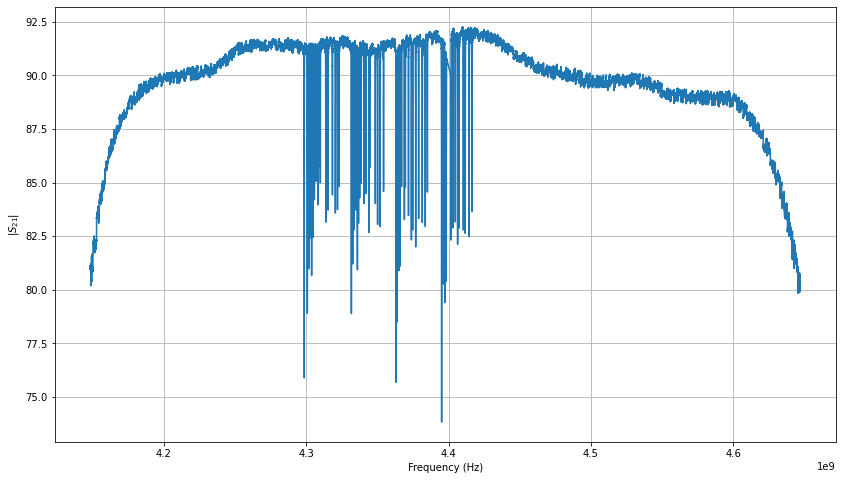

In [3]:
dm.plot_s21([initial_lo_sweep])

## 2) Enter Frequency Region for Cable Delay Calculation

In [4]:
delay_region_start = 4.2e9  #Hz
delay_region_stop =  4.25e9 #Hz

## 3) Measure Cable Delay

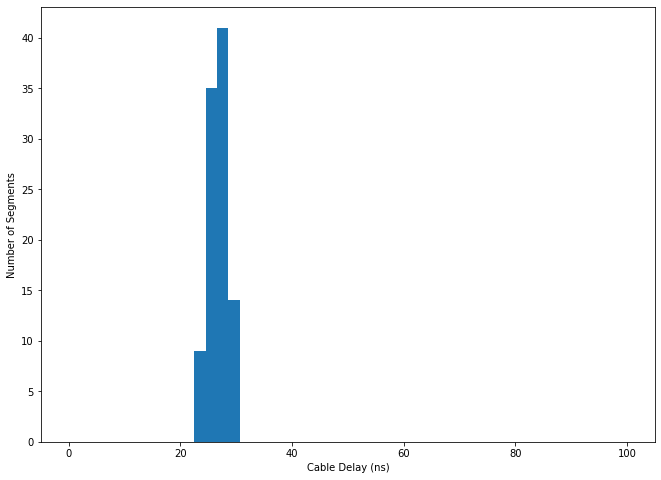

In [5]:
# Measure
delays = dm.measure_delay_test_given_freq(initial_lo_sweep,4.2e9,4.25e9,plot=True)

## 4) Remove Cable Delay

In [6]:
#remove cable delay from target sweep and timestream
#plot S21 phase -> when there is no resonance it is the cable delay
targeted_lo_sweep_rm=dm.remove_delay(targeted_lo_sweep,np.median(delays))
IQ_stream_rm=dm.remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,np.median(delays))

## 5) Measure Circle Parameters (per channel)

In [55]:
#Jiansong Gao Thesis Method
calibration=dm.measure_circle_allch(targeted_lo_sweep_rm,tone_freqs) #finds circle center and initial phase for every channel

## 6) Calibrate Time Stream Data (per channel)

In [56]:
data_cal=dm.get_phase(IQ_stream_rm,calibration)

## 7) View Time Stream Data (per channel)

In [64]:
%matplotlib qt 
dm.plot_timestream(ts_fr, data_cal, start_time = 0, end_time = 10, channel_nums = [20])

## 8) Find nphi_0

In [59]:
%matplotlib qt
f_sawtooth = 5 #Hz

n_phi0 = dm.find_n_phi0(ts_fr,data_cal,f_sawtooth,plot=True)

print(f'n_phi0 = {n_phi0}')

n_phi0 = 3.3509863881038218


## 9) Find t0 (beginning of first flux ramp)

In [11]:
t0_array = np.array([])
for current_channel in range(len(data_cal)):
    t0 = dm.mea_reset_t0(ts_fr,data_cal[current_channel],f_sawtooth,plot=True)
    t0_array = np.append(t0_array,t0)
    
t0_med = np.nanmedian(t0_array)
print(t0_array)
print(t0_med)

[0.09704337        nan 0.01942377        nan 0.01923571        nan
        nan 0.01967459        nan        nan        nan        nan
        nan 0.02004452        nan        nan        nan 0.01973627
        nan        nan        nan        nan 0.01923571 0.01934118
        nan        nan        nan        nan 0.01976912        nan
 0.02004452        nan        nan 0.08003936 0.02026801 0.01988306
 0.01988306        nan 0.02000656 0.01988306        nan        nan
 0.01988306 0.01966488        nan        nan 0.01973734        nan
 0.0202322         nan 0.0804944  0.01965518        nan 0.01988306
 0.01988306        nan        nan        nan 0.01994481 0.01591682
 0.01509876 0.01601062        nan]
0.019883060455322177


/home/matt/.local/readout/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matt/.local/readout/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 9) Demodulate and View Results 

In [65]:
channel = 25

start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
t_demod, data_demod = dm.demodulate(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[channel, start_idx:], n_phi0, f_sawtooth, plot = True, plot_len = None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5356
10.967242956161499
54
0
0.09842729568481445
1
0.29929351806640625
2
0.4998204708099365
3
0.6984195709228516
4
0.8992633819580078
5
1.0997178554534912
6
1.298619270324707
7
1.4994831085205078
8
1.700071096420288
9
1.8989105224609375
10
2.099287986755371
11
2.300139904022217
12
2.49873685836792
13
2.6995689868927
14
2.900210380554199
15
3.0987868309020996
16
3.2995424270629883
17
3.500270128250122
18
3.699033737182617
19
3.8996033668518066
20
4.100347280502319
21
4.298595666885376
22
4.499671459197998
23
4.700403928756714
24
4.899069786071777
25
5.09952449798584
26
5.300416707992554
27
5.498987197875977
28
5.699684143066406
29
5.900540351867676
30
6.098951101303101
31
6.299861907958984
32
6.5005950927734375
33
6.69920539855957
34
6.8999388217926025
35
7.1006505489349365
36
7.2990946769714355
37
7.500028848648071
38
7.700705528259277
39
7.899326324462891
40
8.099823713302612
41
8.300800085067749
42
8.499430894851685
43
8.699977397918701
44
8.90070128440857
45
9.099270582199097
46
9.2

In [28]:


print(t_demod)
print(data_demod)

[0.09822726 0.29881072 0.49942374 0.69822454 0.89905357 1.09978032
 1.30026007 1.49921155 1.69970632 1.90033269 2.10103679]
[-0.0285189   0.30081974 -0.06479811 -0.09229021 -0.06340776 -0.06427201
  0.10883959 -0.03117873 -0.00046995 -0.02442674 -0.04029692]
